In [38]:
from matplotlib import pyplot as plt
from skimage.color import rgb2hed, hed2rgb
from skimage import img_as_float, img_as_ubyte
from skimage import data, io, filters, exposure
from skimage import util
import matplotlib as mp
import numpy as np
import math as mt

from pylab import *
from scipy import *

from ipywidgets import *

%matplotlib inline  

# ROZWAZANY PRZEDZIAL ([T0, T1])
signalScale = [0.0, 20.0]
# WYSWIETLANA SKALA NA WYKRESIE (DZIEDZINA CZASU)
timePlotXScale = [0.0, 20.0]
# WYSWIETLANA SKALA Y (DZIEDZINA CZASU)
timePloyYScale = [-3.0, 3.0] 

def changeX(left = 10, right = 20, speed = 10.0):
    def dynamicX(x):
        result = x
        if x >= left and x <= right:
            angle = (x - left)/(right-left)*(mt.pi)
            shift = (mt.cos(angle + mt.pi) + 1.0) / 2.0
            result = result + shift * speed
        if x > right:
            result = result + 1.0 * speed
        return result
    return dynamicX

def changeY(left = 5, right = 15, amplitude = 1.0):
    def dynamicY(y, x):
        result = y
        if x >= left and x <= right:
            angle = (x - left)/(right-left)*(2.0*mt.pi)
            shift = (mt.cos(angle + mt.pi) + 1.0) / 2.0
            result = y + shift * amplitude
        return result
    return dynamicY



# KLASA SCENARIO
# PO PROSTU LISTA SIGNALOW 
class Scenario(Widget):
    def __init__(self, signals):
        self.signals = signals
        
# KLASA SYGNAL - PROSTY(SIN)
class Signal:
    def __init__(self, amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color='blue', 
                 changeX=changeX(-1,-1,0), changeY=changeY(-1,-1,0)):
        self.amplitude = amplitude
        self.frequency = frequency
        self.phase = phase
        self.yTranslation = yTranslation
        self.color = color
        self.changeX = changeX
        self.changeY = changeY
        
    #LISTA X, Y DLA ZADANEGO PRZEDZIALU I CZESTOTLIWOSCI PROBKOWANIA
    def getDataForRange(self, scale, samplingFrequency):
        x = np.arange(scale[0], scale[1], 1.0 / samplingFrequency)
        fs = lambda a: (self.amplitude * mt.sin(self.phase + self.changeX(a) * self.frequency * 2.0 * mt.pi) + self.yTranslation)
        y = [self.changeY(fs(a), a) for a in x ]
        return x, y

# WYLICZA WYNIKOWY SYGNAL ZE SKLADOWYCH
def getFinalSignal(signals, samplingFrequency):
    x = []
    y = []
    for s in signals:
        data = s.getDataForRange(signalScale, samplingFrequency)
        if len(x) == 0: x = data[0]
        if not y: y = [0] * len(x)
        for i in range(len(x)):
            y[i] = y[i] + data[1][i]
    return x, y
   
# --- RYSOWANIE WSZYSTKIEGO
# --- SINGLE - NA WEJSCIU PARAMETRY DLA POJEDYNCZEGO SYGNALU
# --- ALL - NA WEJSCIU SCENARIO



def plotSingle( amplitude = 1.0, 
                frequency = 0.5, 
                phase = 0.0, 
                yTranslation = 0.0,
                samplingFrequency = 10.0, 
                showComponents = True, 
                showFinal=False, 
                showFrequencyDomain=False, 
                showSymmetrical=False,
                showInverseFFT=False):
    
    scenario = Scenario([Signal(amplitude, frequency, phase, yTranslation)])
    plotAll(scenario, samplingFrequency, showComponents, showFinal, showFrequencyDomain, showSymmetrical, showInverseFFT)
    
def plotAllWithNoiseCancel(scenario = Scenario([Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color='blue')]),
            samplingFrequency = 10.0, 
            noiseThreshold = 10000.0,
            showComponents = True, 
            showFinal=False, 
            showFrequencyDomain=False, 
            showSymmetrical=False, 
            showInverseFFT=False,
            showSpectrogram=False,
            windowSize = 2.0,
            windowJump = 0.5):
    
    signals = scenario.signals
    
    # --- CONSTRUCT FIGURE AND SUBPLOTS ------------------------
    if showFrequencyDomain == True or showInverseFFT == True or showSpectrogram == True:
        column_width_pt = 1000.0
    else:
        column_width_pt = 500.0
        
    pt_per_inch = 72
    size = column_width_pt / pt_per_inch;
    height = 0.55
    
    total = 1
    if showFrequencyDomain == True: total = total + 1
    if showInverseFFT == True: total = total + 1
    if showSpectrogram == True: total = total + 1
    if total == 2: height = 0.37
    if total == 3: height = 0.37

    fig = plt.figure(1, figsize=(size, height * size))
    sub = fig.add_subplot(1, total, 1)
    if showFrequencyDomain == True:
        subFreq = fig.add_subplot(1, total, 2)
    if showInverseFFT == True:
        if (showFrequencyDomain == False):
            subIFFT = fig.add_subplot(1, total, 2)
        else:
            subIFFT = fig.add_subplot(1, total, 3)

    if showSpectrogram == True:
        subSpectr = fig.add_subplot(1, total, total)
    # ------------------------------------------------------
    # --- TIME DOMAIN --------------------------------------
            
    sub.set_xlabel('Time [s]')
    sub.set_ylabel('y = signal(x)')
    sub.grid('on', axis='both', color='gray', linewidth=1.25)
    
    sub.set_xlim(timePlotXScale)
    sub.set_ylim(timePloyYScale)
    
    if showComponents == True:
        for s in range(len(signals)):
            data = signals[s].getDataForRange(signalScale, samplingFrequency)
            #ŻEBY BYLO PRZEJRZYSCIEJ
            if (samplingFrequency < 8.0):
                sub.plot(data[0], data[1], marker='o', linestyle='---', color = signals[s].color)
            else:
                sub.plot(data[0], data[1], linestyle='-', color = signals[s].color)
    
    dataFinal = getFinalSignal(signals, samplingFrequency)
    if (showFinal):
        dataFinal = getFinalSignal(signals, samplingFrequency)
        sub.plot(dataFinal[0], dataFinal[1], linestyle='-', linewidth = 2.0, color = 'red')
        
    # ------------------------------------------------------
    # --- FREQUENCY DOMAIN --------------------------------------
    
    ind = np.arange(len(dataFinal[0]))  # the x locations for the groups   
    signal1 = np.fft.fft(dataFinal[1])
    signal2 = abs(signal1) 

    ffty = signal2
    freq = [v * samplingFrequency / len(dataFinal[0]) for v in ind]
    
    # USUWAMY PASMO
    signal3 = []
    for i in range(len(freq)):
        if noiseThreshold <= samplingFrequency / 2:
            if freq[i] <= samplingFrequency / 2 and freq[i] >= noiseThreshold:
                ffty[i] = 0.0
                signal1[i] = 0.0
            if freq[i] >= samplingFrequency / 2 and freq[i] <= samplingFrequency - noiseThreshold:
                ffty[i] = 0.0
                signal1[i] = 0.0
    
    if showSymmetrical == False:
        freq = freq[0:int(len(signal2)/ 2)]
        ffty = ffty[0:int(len(signal2)/ 2)]
 
    if showFrequencyDomain == True:
        
        subFreq.set_xlabel('Frequency [Hz]')
        subFreq.set_ylabel('Amplitude')
        subFreq.grid('on', axis='both', color='gray', linewidth=1.25)
            
        #TRANSFORM
        width = 0.15
        x = [v - width / 2 for v in freq]
        subFreq.set_ylim([0.0, 300.0])           
        barFreq = subFreq.bar(x, ffty,width, color='blue')
    
    # ------------------------------------------------------
    # --- INVERSE FFT --------------------------------------
    if showInverseFFT == True:
        subIFFT.set_xlabel('Time [s]')
        subIFFT.set_ylabel('y = signal(x)')
        subIFFT.grid('on', axis='both', color='gray', linewidth=1.25)
    
        subIFFT.set_xlim(timePlotXScale)
        subIFFT.set_ylim(timePloyYScale)
        
        signalIFFT = np.fft.ifft(signal1)
        
        
        subIFFT.plot(dataFinal[0], np.real(signalIFFT), linestyle='-', linewidth = 2.0, color = 'red')
   
    # ------------------------------------------------------
    # --- SHOW SPECTROGRAM --------------------------------------
    if showSpectrogram == True:
        subSpectr.set_xlabel('Time [s]')
        subSpectr.set_ylabel('Frequency [Hz]')
        subSpectr.grid('on', axis='both', color='gray', linewidth=1.25)
    
        xlabel = []
        data = []
        
        timesX = 0
        
        start = 0;
        startInDomain = 0
        windowSizeInDomain = windowSize * samplingFrequency
        jumpInDomain = windowJump * samplingFrequency
        
        while startInDomain + windowSizeInDomain <= len(dataFinal[0]):
            timesX += windowJump
            xlabel.append(start)
            portion = []
            for i in range(int(startInDomain), int(startInDomain + windowSizeInDomain)):
                 portion.append(dataFinal[1][i])
                    
            toAdd = abs(np.fft.fft(portion))
            if showSymmetrical == False:
                toAdd = toAdd[0:int(len(toAdd)/ 2)]
                
            data.append(toAdd)
            
            start += windowJump
            startInDomain += jumpInDomain
            
            
        npdata = np.array(data)
        npdata = np.transpose(npdata)
        
        
        print(timesX)
        #ticks = np.arange(0, 1000, 10)
        labels = np.linspace(0, timesX, 10)
        labels = [int(l) for l in labels]
        print(labels)
        #subSpectr.xticks(ticks, labels)
    
        #subSpectr.set_xticks(ticks)
        subSpectr.set_xticklabels(labels)
        
        #subSpectr.set_xlim(0, len(npdata[0]))
        subSpectr.set_ylim(0, len(npdata))
        
     
    
        heatmap = subSpectr.pcolor(npdata)
        fig.colorbar(heatmap)
        
        
    plt.show()
    
def plotSpectrogram(scenario = Scenario([Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color='blue')]),
            samplingFrequency = 10.0, 
            showComponents = True, 
            showFinal=False, 
            showFrequencyDomain=False, 
            showSymmetrical=False, 
            showSpectrogram=False,
            windowSize = 2.0,
            windowJump = 0.5):
    
    plotAllWithNoiseCancel(scenario, samplingFrequency, 1000000.0, showComponents, showFinal, 
                           showFrequencyDomain, showSymmetrical, False, showSpectrogram,
            windowSize,
            windowJump)
    
    
def plotAllWithNoiseCancelWithoutSpectrogram(scenario = Scenario([Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color='blue')]),
            samplingFrequency = 10.0, 
            noiseThreshold = 10000.0,
            showComponents = True, 
            showFinal=False, 
            showFrequencyDomain=False, 
            showSymmetrical=False, 
            showInverseFFT=False):
    
    plotAllWithNoiseCancel(scenario, samplingFrequency, noiseThreshold, showComponents, showFinal, 
                           showFrequencyDomain, showSymmetrical, showInverseFFT, showSpectrogram=False,
            windowSize = 2.0,
            windowJump = 0.5)
    
# --- WA - BEZ CZESCI PARAMETROW TRUE/FALSE - INACZEJ NIE WIEM JAK WYWALIC WIDGET Z INTERACT
# --- WIFFT - BEZ PARAMETROW IFFT - INACZEJ NIE WIEM JAK WYWALIC WIDGET Z INTERACT
def plotAll(scenario = Scenario([Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color='blue')]),
            samplingFrequency = 10.0, 
            showComponents = True, 
            showFinal=False, 
            showFrequencyDomain=False, 
            showSymmetrical=False, 
            showInverseFFT=False): 
    
    plotAllWithNoiseCancel(scenario, samplingFrequency, 10000.0, showComponents, showFinal, 
                           showFrequencyDomain, showSymmetrical, showInverseFFT, showSpectrogram=False,
            windowSize = 10,
            windowJump = 3)

def plotSingleWithoutAll(   
    amplitude = 1.0, 
    frequency = 0.5, 
    phase = 0.0, 
    yTranslation = 0.0,
    samplingFrequency = 10.0):
    
    scenario = Scenario([Signal(amplitude, frequency, phase, yTranslation)])
    plotAll(scenario, samplingFrequency)

def plotSingleWIFFT(
    amplitude = 1.0, 
    frequency = 0.5, 
    phase = 0.0, 
    yTranslation = 0.0,
    samplingFrequency = 10.0, 
    showComponents = True, 
    showFinal=False, 
    showFrequencyDomain=False, 
    showSymmetrical=False):
    
    scenario = Scenario([Signal(amplitude, frequency, phase, yTranslation)])
    plotAll(scenario, samplingFrequency, showComponents, showFinal, showFrequencyDomain, showSymmetrical)
    
def plotAllWithoutAll(   
    scenario = Scenario([Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color='blue')]),
    samplingFrequency = 10.0, 
    showComponents = True, 
    showFinal=False):
    
    plotAll(scenario, samplingFrequency,showComponents, showFinal)

    
        



# SYGNAL W DZIEDZINIE CZASU

## Podstawowe cechy, czestotliwosc probkowania, nyquista

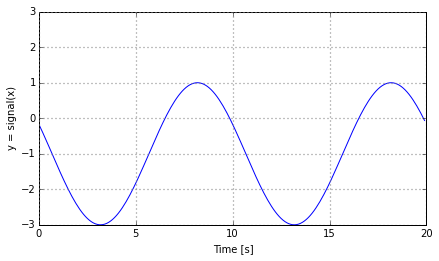

In [39]:
interact(plotSingleWithoutAll, amplitude=(0.5,2.5,0.1),
         frequency=(0.1, 2.0,0.1),phase = (-2.0 * mt.pi, 2.0*mt.pi, 0.25), 
         yTranslation = (-2.5, 2.5, 0.5), samplingFrequency=(0.25,10,0.25));

$$u(t) = A \cdot sin(2\cdot \pi \cdot f_{0} \cdot t + \varphi) + y_{0}$$

Jaka musi być częstotliwość sygnału, aby jego przebieg się (jeden, pełen) się skończył w 5s?

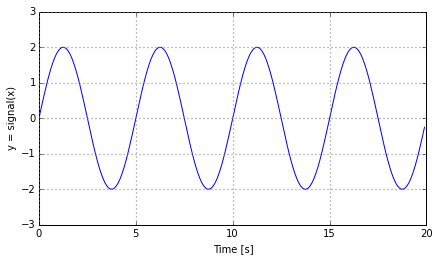

In [40]:
x = 1/5
plotSingleWithoutAll( 2, frequency = x, phase = 0, yTranslation = 0, samplingFrequency=10)

Jaka musi być częstotliwość sygnału, aby jego przebieg się (jeden, pełen) się skończył w 0.5s?

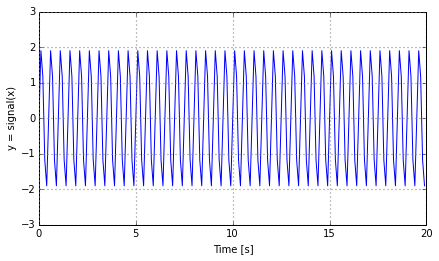

In [41]:
x = 2
plotSingleWithoutAll( 2, frequency= x, phase = 0, yTranslation = 0, samplingFrequency=10)

## Sumowanie sygnałow

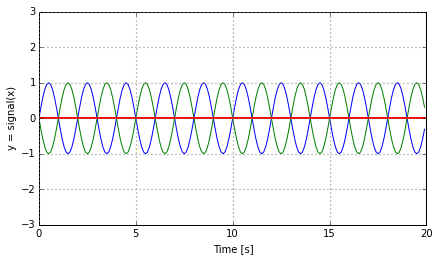

In [42]:
sc1 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude = 2.0, frequency = 0.25, phase = 0.0, yTranslation = 0.0, color = 'green') ])
sc2 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude = 1.25, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'green') ])
sc3 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude = 1.0, frequency = 0.5, phase = mt.pi, yTranslation = 0.0, color = 'green') ])



scenarios = {"1. Przyklad": sc1 , "2. Wzmocnienie" : sc2, "3. Tlumienie" : sc3}
interact(plotAllWithoutAll, scenario=scenarios, samplingFrequency=(0.25,10,0.25));



# Sygnal w dziedzinie czestotliwosci

## Omowienie podstaw

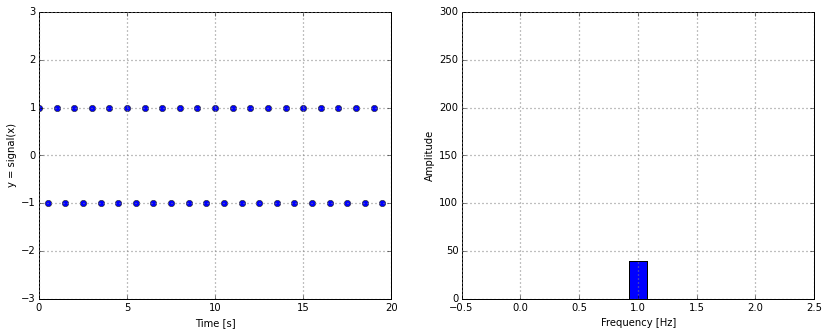

In [51]:
#FFT
interact(plotSingleWIFFT, amplitude=(0.5,2.5,0.1),
         frequency=(0.0, 2.0,0.1),phase = (-2.0 * mt.pi, 2.0*mt.pi, 0.25), 
         yTranslation = (-2.5, 2.5, 0.5), samplingFrequency=(0.25,10,0.25));

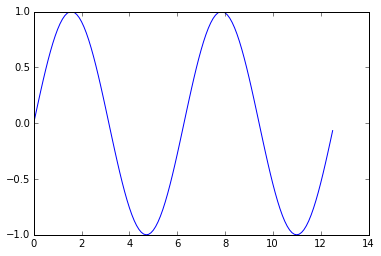

In [44]:
x = np.arange(0, 2 * 2*np.pi, 0.1)
y = np.sin(x)
plt.plot(x, y)

In [47]:
#len(y)
#y
#raw_fd = np.fft.fft(y)
print(raw_fd)
#len(raw_fd)
#len(raw_fd)

[-0.01116209 +0.00000000e+00j -0.00929075 -2.23298636e-01j
  1.04382500 -6.29042355e+01j -0.02138338 +4.05878821e-01j
 -0.01871445 +2.24596212e-01j -0.01790011 +1.60002591e-01j
 -0.01752729 +1.25668596e-01j -0.01732179 +1.03954423e-01j
 -0.01719537 +8.88122197e-02j -0.01711166 +7.75692418e-02j
 -0.01705320 +6.88474020e-02j -0.01701068 +6.18581407e-02j
 -0.01697876 +5.61149914e-02j -0.01695416 +5.13002832e-02j
 -0.01693479 +4.71971182e-02j -0.01691927 +4.36519944e-02j
 -0.01690663 +4.05530209e-02j -0.01689620 +3.78165956e-02j
 -0.01688749 +3.53789240e-02j -0.01688015 +3.31904357e-02j
 -0.01687390 +3.12119992e-02j -0.01686854 +2.94122909e-02j
 -0.01686391 +2.77659265e-02j -0.01685988 +2.62521059e-02j
 -0.01685635 +2.48536161e-02j -0.01685324 +2.35560833e-02j
 -0.01685050 +2.23474061e-02j -0.01684806 +2.12173196e-02j
 -0.01684589 +2.01570562e-02j -0.01684394 +1.91590793e-02j
 -0.01684219 +1.82168722e-02j -0.01684062 +1.73247684e-02j
 -0.01683920 +1.64778154e-02j -0.01683791 +1.56716634e-0

In [48]:
fd = np.abs(raw_fd)
print(fd)

[  1.11620912e-02   2.23491832e-01   6.29128955e+01   4.06441713e-01
   2.25374553e-01   1.61000755e-01   1.26884995e-01   1.05387696e-01
   9.04615454e-02   7.94342260e-02   7.09279663e-02   6.41544459e-02
   5.86273872e-02   5.40292753e-02   5.01433462e-02   4.68162174e-02
   4.39361076e-02   4.14195174e-02   3.92027509e-02   3.72363332e-02
   3.54812269e-02   3.39062018e-02   3.24859665e-02   3.11998150e-02
   3.00306289e-02   2.89641304e-02   2.79883160e-02   2.70930207e-02
   2.62695791e-02   2.55105593e-02   2.48095521e-02   2.41610019e-02
   2.35600702e-02   2.30025250e-02   2.24846500e-02   2.20031697e-02
   2.15551876e-02   2.11381343e-02   2.07497244e-02   2.03879199e-02
   2.00508991e-02   1.97370307e-02   1.94448511e-02   1.91730455e-02
   1.89204312e-02   1.86859435e-02   1.84686234e-02   1.82676069e-02
   1.80821158e-02   1.79114500e-02   1.77549800e-02   1.76121409e-02
   1.74824276e-02   1.73653896e-02   1.72606272e-02   1.71677883e-02
   1.70865649e-02   1.70166909e-02

In [18]:
2.0 * np.pi

6.283185307179586

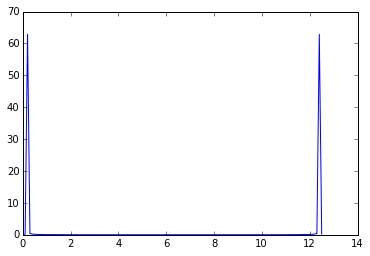

In [49]:
plt.plot(x, fd)

In [ ]:
https://pl.wikipedia.org/wiki/Twierdzenie_Kotielnikowa-Shannona

## Suma sygnalow w dziedzinie czasu a efekt w dziedzinie czestotliwosci.

## Odwrotne FFT

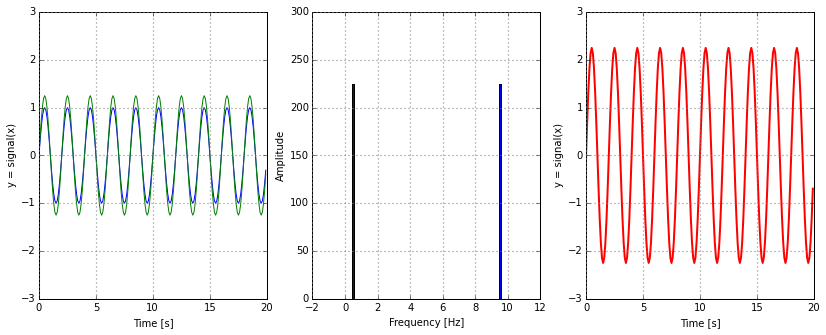

In [53]:

 
sc1 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude = 2.0, frequency = 0.25, phase = 0.0, yTranslation = 0.0, color = 'green') ])
sc2 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude = 1.25, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'green') ])
sc3 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude = 1.0, frequency = 0.5, phase = mt.pi, yTranslation = 0.0, color = 'green') ])

scenarios = {"1. Przyklad": sc1 , "2. Wzmocnienie" : sc2, "3. Tlumienie" : sc3}
interact(plotAll, scenario=scenarios, samplingFrequency=(0.25,10,0.25));




In [21]:
x = np.arange(0, 2 * 2*np.pi, 0.1)
y = np.sin(x)
print(y)

[ 0.          0.09983342  0.19866933  0.29552021  0.38941834  0.47942554
  0.56464247  0.64421769  0.71735609  0.78332691  0.84147098  0.89120736
  0.93203909  0.96355819  0.98544973  0.99749499  0.9995736   0.99166481
  0.97384763  0.94630009  0.90929743  0.86320937  0.8084964   0.74570521
  0.67546318  0.59847214  0.51550137  0.42737988  0.33498815  0.23924933
  0.14112001  0.04158066 -0.05837414 -0.15774569 -0.2555411  -0.35078323
 -0.44252044 -0.52983614 -0.61185789 -0.68776616 -0.7568025  -0.81827711
 -0.87157577 -0.91616594 -0.95160207 -0.97753012 -0.993691   -0.99992326
 -0.99616461 -0.98245261 -0.95892427 -0.92581468 -0.88345466 -0.83226744
 -0.77276449 -0.70554033 -0.63126664 -0.55068554 -0.46460218 -0.37387666
 -0.2794155  -0.1821625  -0.0830894   0.0168139   0.1165492   0.21511999
  0.31154136  0.40484992  0.49411335  0.57843976  0.6569866   0.72896904
  0.79366786  0.85043662  0.8987081   0.93799998  0.96791967  0.98816823
  0.99854335  0.99894134  0.98935825  0.96988981  0

In [22]:
yp = np.fft.ifft(np.fft.fft(y))
print(y)

[ 0.          0.09983342  0.19866933  0.29552021  0.38941834  0.47942554
  0.56464247  0.64421769  0.71735609  0.78332691  0.84147098  0.89120736
  0.93203909  0.96355819  0.98544973  0.99749499  0.9995736   0.99166481
  0.97384763  0.94630009  0.90929743  0.86320937  0.8084964   0.74570521
  0.67546318  0.59847214  0.51550137  0.42737988  0.33498815  0.23924933
  0.14112001  0.04158066 -0.05837414 -0.15774569 -0.2555411  -0.35078323
 -0.44252044 -0.52983614 -0.61185789 -0.68776616 -0.7568025  -0.81827711
 -0.87157577 -0.91616594 -0.95160207 -0.97753012 -0.993691   -0.99992326
 -0.99616461 -0.98245261 -0.95892427 -0.92581468 -0.88345466 -0.83226744
 -0.77276449 -0.70554033 -0.63126664 -0.55068554 -0.46460218 -0.37387666
 -0.2794155  -0.1821625  -0.0830894   0.0168139   0.1165492   0.21511999
  0.31154136  0.40484992  0.49411335  0.57843976  0.6569866   0.72896904
  0.79366786  0.85043662  0.8987081   0.93799998  0.96791967  0.98816823
  0.99854335  0.99894134  0.98935825  0.96988981  0

## Fajne zastosowanie FFT i iFFT

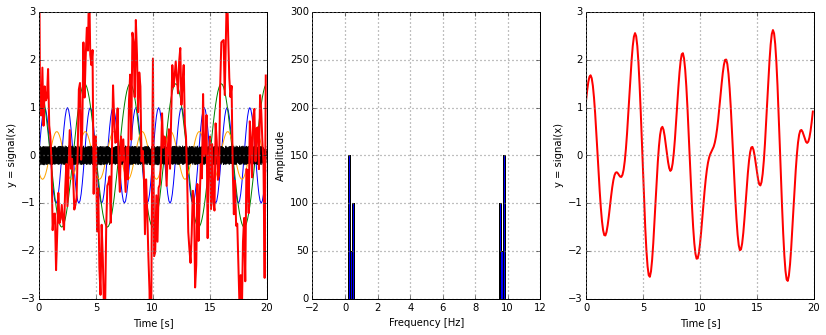

In [54]:

l1 = [
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude = 1.5, frequency = 0.25, phase = 0.5 * mt.pi, yTranslation = 0.0, color = 'green'),
        Signal(amplitude = 0.5, frequency = 0.4, phase = 1.25 * mt.pi, yTranslation = 0.0, color = 'orange')]

l2 = [
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude = 1.5, frequency = 0.25, phase = 0.5 * mt.pi, yTranslation = 0.0, color = 'green'),
        Signal(amplitude = 0.5, frequency = 0.4, phase = 1.25 * mt.pi, yTranslation = 0.0, color = 'orange')]

for i in range(50):
    amplitude = 0.05 + random.random() * 0.15
    #Round - Uniknięcie błędów numerycznych, co sie stanie po usunieciu round?
    # frequency = round(1.0 + random.random() * 3.0, 1)
    frequency = round(1.0 + random.random() * 3.0, 1) 
    phase = random.random() * mt.pi
    color = 'black'
    l2.append(Signal(amplitude, frequency, phase, 0.0, color))

sc1 = Scenario(l1)
sc2 = Scenario(l2)

scenarios = {"1. Przyklad": sc1, "2. Noise": sc2 }
interact(plotAllWithNoiseCancelWithoutSpectrogram, scenario=scenarios, noiseThreshold=6.0, samplingFrequency=(0.25,10,0.25));


In [24]:
a = np.eye(4)
print(a)

[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


In [25]:
fd = np.fft.fft2(a)
print(fd)

[[ 4.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  4.+0.j]
 [ 0.+0.j  0.+0.j  4.+0.j  0.+0.j]
 [ 0.+0.j  4.+0.j  0.+0.j  0.+0.j]]


In [26]:
d = np.fft.ifft2(fd)
print(d)

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]


In [27]:
d = np.fft.ifft2(fd)
print(np.abs(d))

[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


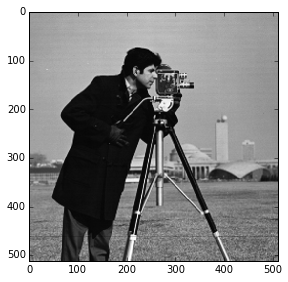

In [55]:
cam = img_as_float(data.camera())
io.imshow(cam)

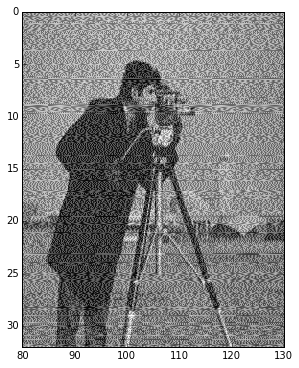

In [56]:
#imgProc = util.random_noise(cam, mode='s&p', amount=0.3)  
#imgProc = util.random_noise(cam, mode='gaussian', mean=0, var=0.2)

imgProc = np.empty_like(cam)
imgProc[:] = cam

for y in range(0, imgProc.shape[0]):
    phi = (random.random() * 100)
    freq = 0.2 + random.random() * 0.5
    for x in range(0, imgProc.shape[1]):
        ab = 0.3 * sin(2*np.pi * freq * x + phi)
        #imgProc[y][x] = ab
        imgProc[y][x] += ab


#io.imshow(imgProc,cmap='gray', interpolation='none')
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(imgProc,cmap='gray', interpolation='none', extent=[80,130,32,0])
ax.set_aspect(2) # you may also use am.imshow(..., aspect="auto") to restorel the

In [57]:
fd = np.fft.fft2(imgProc)

In [58]:
fdp = np.abs(fd)
print(fdp)

[[ 121631.21687749   19781.6414037     8052.135773   ...,    4407.17485241
     8052.135773     19781.6414037 ]
 [  17095.96537746   15222.84127426   10037.35154285 ...,    2533.0428802
     4124.92183594    4931.34560214]
 [   8362.67859153    4957.90565126    2317.2368536  ...,    2595.39529319
     1504.86583095    3264.98270783]
 ..., 
 [   2962.68836832    1857.67359908    2246.79033703 ...,    2595.59183125
     2287.61693789    1370.31389981]
 [   8362.67859153    3264.98270783    1504.86583095 ...,    2441.25715014
     2317.2368536     4957.90565126]
 [  17095.96537746    4931.34560214    4124.92183594 ...,    2999.29958486
    10037.35154285   15222.84127426]]


0.000744179516874


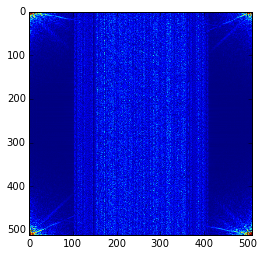

In [59]:
m = np.max(fdp)
copy = fdp / m
print(np.mean(copy))
norm = (copy - 0) / (0.01 - 0)
norm[norm > 1] = 1
norm[norm < 0] = 0
plt.imshow(norm)

(512, 512)


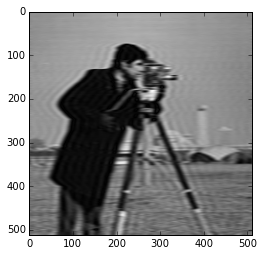

In [61]:
print(fd.shape)
w = fd.shape[1]
h = fd.shape[0]

prop = 0.9
copy = np.empty_like(fd)
copy[:] = fd

#copy[int(h/2 - h/2 * prop): int(h/2 + h/2* prop), int(w/2 - w/2 * prop): int(w/2 + w/2* prop)] = 0
copy[0:h, int(w/2 - w/2 * prop): int(w/2 + w/2* prop)] = 0



new_img = np.fft.ifft2(copy)
#print(new_img)
plt.imshow(np.abs(new_img),cmap='gray')

Pojedynczy sygnal - zmienny w czasie

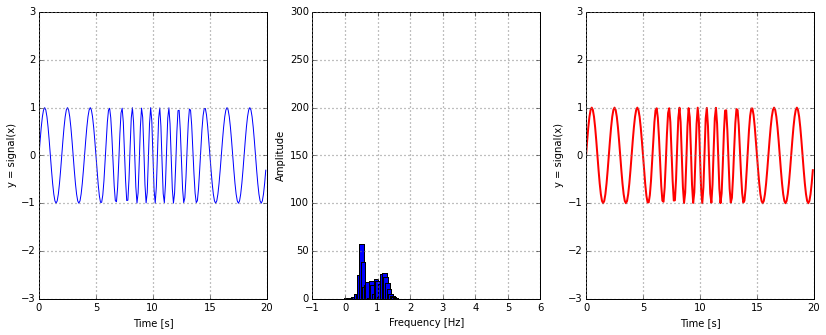

In [62]:


sc1 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue', 
               changeX=changeX(5,15,10))])
sc2 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue', 
               changeY=changeY(5,15,1))])
sc3 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue', 
               changeX=changeX(10,20,10), changeY=changeY(0,10,1))])


scenarios = {"1. Zmienna czestotliwosc": sc1 , "2. Zmienna amplituda" : sc2, "3. Mix" : sc3}
interact(plotAll, scenario=scenarios, samplingFrequency=(0.25,10,0.25));




## Spectrogram

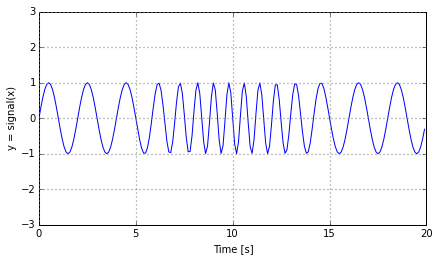

In [63]:

sc1 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue', 
               changeX=changeX(5,15,10))])
sc2 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue', 
               changeY=changeY(5,15,1))])
sc3 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue', 
               changeX=changeX(10,20,10), changeY=changeY(0,10,1))])

scenarios = {"1. Czestotliwosc": sc1, "2. Amplituda": sc2, "3. Mix": sc3   }
interact(plotSpectrogram, scenario=scenarios, samplingFrequency=(0.25,10,0.25), windowSize=(4.0,10.0,0.25), 
         windowJump=(0.25,2.0,0.25));


In [ ]:
https://pl.wikipedia.org/wiki/Okno_czasowe